Place light bulbs in the grid so as to light up all the blank squares. A light illuminates its own square and all the squares in the same row or column unless blocked by walls (black squares). Lights may not illuminate each other. Each numbered square must be orthogonally adjacent to exactly the given number of lights.

Click on a square to place or remove a light. Right-click to place a dot indicating that you think there is no light in that square. 

In [1]:
%matplotlib inline

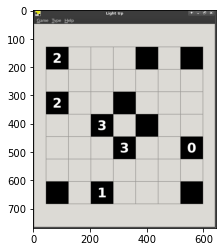

In [2]:
import numpy
import pylab
import matplotlib.pyplot as plt

I = pylab.imread('lightup.png')

plt.imshow(I)

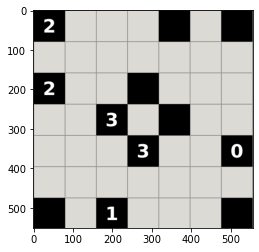

In [3]:
plt.imshow(I[129:680,44:600])

In [4]:
Nrows = 7
Ncols = 7

#Black boxes
black = [
 (0,0),(0,4),(0,6),
 
 (2,0),(2,3),
 (3,2),(3,4),
 (4,3),(4,6),
 (6,0),(6,2),(6,6)
]
#Hints
hints = [
 (0,0,2), (2,0,2), (3,2,3), (4,3,3), (4,6,0), (6,2,1)
]

EASY1 = [black, hints]
Easy1Image = pylab.imread('lightup.png'),129,44,680,600

In [5]:

def vecinos(j,k):
    vs = []
    #a la dere
    if k<Ncols-1:
        vs.append((j,k+1))
    #a la zurda
    if k>0:
        vs.append((j,k-1))
    #debajo
    if j<Nrows-1:
        vs.append((j+1,k))
    #arriba
    if j>0:
        vs.append((j-1,k))
    return vs

def LightupMILP(black, hints):
    R = Nrows*Ncols
    
    pasillo = numpy.zeros((Nrows, Ncols, Nrows, Ncols))
    #La luz viaja arriba y abajo
    for k in range(Ncols):
        for j1 in range(Nrows):
            for j2 in range(j1):
                pasillo[j1,k,j2,k] = 1
                pasillo[j2,k,j1,k] = 1

    #La luz viaja izq y dere
    for j in range(Nrows):
        for k1 in range(Ncols):
            for k2 in range(k1):
                pasillo[j,k1,j,k2] = 1
                pasillo[j,k2,j,k1] = 1

    for j, k in black:
        #Impide el paso de la luz de arriba abajo
        for j1 in range(0,j+1):
            for j2 in range(j,Nrows):
                pasillo[j1,k,j2,k]=0
                pasillo[j2,k,j1,k]=0
        #Impide el paso de la luz de izq a dere
        for k1 in range(0,k+1):
            for k2 in range(k,Ncols):
                pasillo[j,k1,j,k2]=0
                pasillo[j,k2,j,k1]=0
    
    p = MixedIntegerLinearProgram(maximization=True, solver = "GLPK")
    b = p.new_variable(binary=True)
    i = p.new_variable(binary=True)
    #b[j,k] = 0 si no hay bombilla, 1 si hay bombilla en la posicion j,k
    #i[j,k] = 0 si esta oscura, 1 si hay luz en la posicion j,k
    
    #Hints
    for j,k,n in hints:
        p.add_constraint(sum(b[j0,k0] for (j0,k0) in vecinos(j,k))==n)
        
    #Black boxes
    for j,k in black:
        p.add_constraint(b[j,k]==0)
    
    #Solo se ilumina si hay bombilla
    for j in range(Nrows):
        for k in range(Ncols):
            p.add_constraint(i[j,k] <= sum(b[j0,k0] 
                                           for j0 in range(Nrows)
                                           for k0 in range(Ncols)
                                           if pasillo[j,k,j0,k0]))
                                           
    #No se pueden poner dos bombillas que se iluminan
    for j1 in range(Nrows):
        for j2 in range(Nrows):
            for k1 in range(Ncols):
                for k2 in range(Ncols):
                    if pasillo[j1,k1,j2,k2]:
                        p.add_constraint(b[j1,k1]+b[j2,k2]<=1)
    p.set_objective(
        sum(i[j,k] for j in range(Nrows) for k in range(Ncols)) +
        sum(b[j,k] for j in range(Nrows) for k in range(Ncols)))
    return b,i, p

In [7]:
%time
b,i, p = LightupMILP(black, hints)
print (p.solve())

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs
37.0


In [9]:
d = p.get_values(b)
for j in range(Nrows):
    for k in range(Ncols):
        if d[j,k]:
            print( 'there is a lamp in pos (%d,%d)'%(j,k))

there is a lamp in pos (0,1)
there is a lamp in pos (1,0)
there is a lamp in pos (2,2)
there is a lamp in pos (2,6)
there is a lamp in pos (3,0)
there is a lamp in pos (3,3)
there is a lamp in pos (4,2)
there is a lamp in pos (4,4)
there is a lamp in pos (5,5)
there is a lamp in pos (6,3)


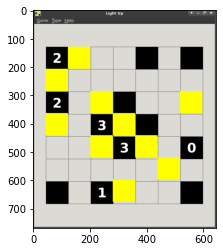

In [10]:
I, Ox, Oy, Ex, Ey = Easy1Image
Dx,Dy = int((Ex-Ox)/Nrows), int((Ey-Oy)/Ncols)
def subslice(j,k):
    return (slice(Ox+j*Dx,Ox+(j+1)*Dx), 
            slice(Oy+k*Dy,Oy+(k+1)*Dy),
            slice(0,4))

yellow = numpy.array([[[1,1,0,1]]])
sol_image = I.copy()
for j in range(Nrows):
    for k in range(Ncols):
        if d[j,k]:
            sol_image[subslice(j,k)] = yellow
plt.imshow(sol_image)